# PCA for day time learning 

### Processing photos

In [10]:
from glob import glob
import pandas as pd 
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# locate all the balcony view images by setting the path to them
view_images = glob('Balcony view/*')

view_data = []
# looping through the paths
for path in view_images:
    # opening images
    with Image.open(path) as image:
        # resizing images to make them have the same dimensions
        cover_v = image.resize((512, 512))
        colored_v = cover_v.convert('RGB')
        # flatten the matrix to an array and append it to all flattened images
        view_data.append(np.array(colored_v).flatten())

### Project images down to a 2 dimensional representation using PCA

In [11]:
from sklearn.decomposition import PCA, NMF
pca = PCA(n_components=2).fit(view_data)

###  2D locations of each photo in the new space

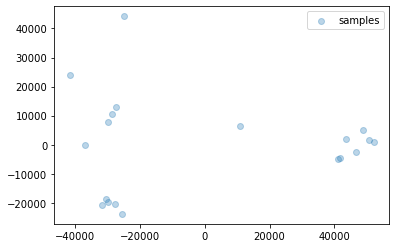

In [12]:
points = pca.transform(view_data)
df = pd.DataFrame(points)
plt.scatter(df[0],df[1], alpha=0.3, label="samples")
plt.legend()
plt.show()

###   Reconstruction from each low-dimensional representation

In [13]:
# calculate PCA results and save image for each dimension
samples = []
expl_var = []
dims = []

for i in range(1,len(view_data)+1,1):
    
    # apply PCA
    pca = PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(view_data)
    
    # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    # save one random sample from each dimension
    random_row = np.random.randint(len(view_data), size=1)
    sample = formatted[random_row]
    
    # calculate explained variance
    pca_var_expl = \
    np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)
    
    # save results
    samples.append(sample)    
    expl_var.append(pca_var_expl)
    dims.append(i)

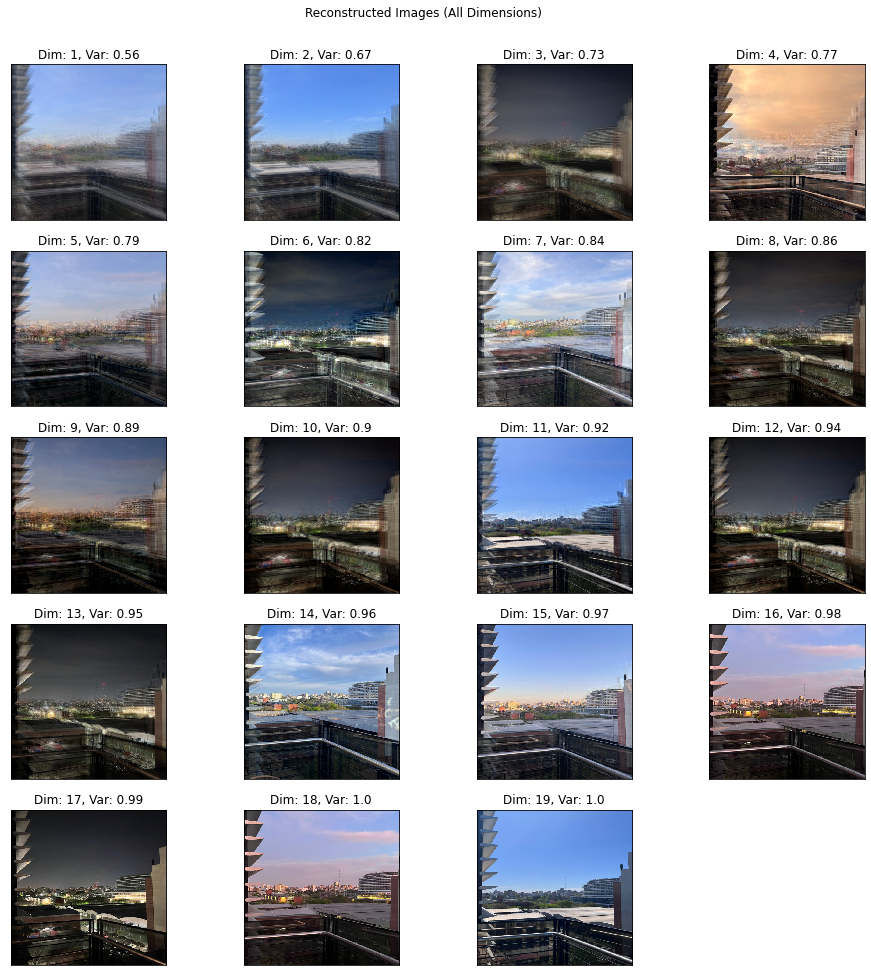

In [14]:
# reshape formatted samples
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(512,512,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 20)) 

for i in range(len(samples)): 
    ax = fig.add_subplot(6, 4, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images (All Dimensions)', y=0.92)

plt.show()

### Picking a point far from the rest and plotting its reconstruction

In [15]:
#point far from the rest
point = [-10000, 20000]

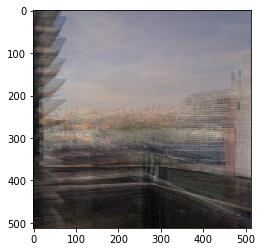

In [16]:
fig, ax = plt.subplots()
pca = PCA(n_components=2).fit(view_data)
view_pca = pca.inverse_transform([point])
formatted = np.clip(view_pca, 0, 255).astype(np.uint8)
img = Image.fromarray(formatted.reshape(512,512,3), 'RGB') 
ax.imshow(img, interpolation='nearest')

## Optional extension

### Predicting the time when the photo was taken and outputting metrics for that model (using Linear Regression)

In [17]:
Times = [18*60+35, 6*60+45, 6*60+54, 8*60+53, 11*60+40, 14*60+5, 14*60+59,
         19*60+20, 20*60+11, 21*60+57, 1*60+23, 6*60+16, 7*60+5, 7*60+26, 
         19*60+58, 19*60+58, 22*60, 22*60+22, 14*60+12]

Halves = [i//720 for i in Times]

times = pd.DataFrame(Times)
halves = pd.DataFrame(Halves)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(view_data, times, test_size= 0.33, random_state= 101)

In [19]:
from sklearn.linear_model import LinearRegression, LogisticRegression

# Instantiating LinearRegression() Model
lr = LinearRegression()

# Training/Fitting the Model
lr.fit(X_train, y_train)

# Making Predictions
lr.predict(X_test)
pred = lr.predict(X_test)

In [20]:
import sklearn 

# Evaluating Model's Performance
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(y_test, pred))
print('Mean Root Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, pred)))

from sklearn.metrics import r2_score
R = r2_score(y_test, pred)
print("R2 score:", R)

Mean Absolute Error: 359.9535592781448
Mean Squared Error: 212433.00329431138
Mean Root Squared Error: 460.9045490058775
R2 score: -0.4301031127513322


All the metrics here are very large, which means that the model is not very accurate. The same tells us the negative r2_score. Basically the linear regression here identifies that the model's predictions are worse than a constant function that always predicts the mean of the data. Mostly it i sbecause of the lack of the data. 

### Predicting the half of the day when the photo was taken and outputting metrics for that model (using Logistic Regression)

In [26]:
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(view_data, halves, test_size= 0.33, random_state= 101)

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

# Making Predictions
logreg.predict(X_test)
pred = logreg.predict(X_test)

In [27]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold 

kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cv_results = cross_val_score(LogisticRegression(), X_train, y_train, cv=kfold, scoring='accuracy')
print("The accuracy for all the folds: ", cv_results)

The accuracy for all the folds:  [1.  0.5 1.  1.  1.  1.  1.  0.  1.  0. ]


Based on the cross-validation results regardless of the fold left for testing the model trained on the rest of the folds predicts accurately one out of the two elements left in the fold most likely. There were three cases when no elements were guessed right. I am not sure though what 0.5 (second value) accuracy means because these numbers should indicate #of correctly predicted data points out of all the data points, which should be an integer.

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix for Logistic Regression")
print('-----------------------------------------------')
print(confusion_matrix(pred, y_test))
print("\n\nClassification report for Logistic Regression")
print('-----------------------------------------------')
print(classification_report(y_test, pred))

Confusion matrix for Logistic Regression
-----------------------------------------------
[[1 1]
 [3 2]]


Classification report for Logistic Regression
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.40      0.67      0.50         3

    accuracy                           0.43         7
   macro avg       0.45      0.46      0.42         7
weighted avg       0.46      0.43      0.40         7



The structure of the Confusion matrix is: [[TP FP], [ FN TN]]

Where TP stands for True Positive, FP - False Positive, FN - False Negative and TP - True Positive. Based on the confusion matrix Logistic regression for this data misclassified the majority of data (FP+FN = 4, the sum of all values in the matrix = 7 --> 4/7 is missclassified.) 

In the classification report we can analyze the precision - fraction of the true positives, recall -fraction of the True Positives in the full Positives list, f1-score, which tells us how much the data is explained by the model and how more precise it is then our guess, support - the number of occurances of a given class in the givan data, and, finally, accuracy - the fraction of both True Positives and True Negatives. 

First of all, the support is really small. I have 7 elements total in the testing set which makes the results of this analysis not really representative. Since the model was not tested (neither it was trained) on a lot of data we cannot say that this model is likely to represent true distribution of the colors of my view from the balcony. 

However, we can still practice making models and interpreting them. 

The accuracy of this model is 43%, which is not too bad given the little data we have. 43% of the halves of the day were predicted accurately. My pokemon logistic model had a lot smaller accuracy, which means the half of the day when the picture was taken is better explained by the pixels of that picture then the type of a pokemon given its own pixels. 

From all the pictures that were predicted to be taken in the 1st half of the day 25% were identified right while it was 67% for the 2nd half of the day based on the recall. However, if we look at the precision if we look at the correctly predicted pictures as a fraction of all the model was more likely to predict the 1st half of the day better (50% of the TP vs 40% of TP  for the 2nd half of the day.)

Finally, based on the f1-score only 33% of the 1st-half-day pictures is explained by the model while it is 50% for the 2nd half of the day.

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
predicted_nb = clf_nb.predict(X_test)

print("Confusion matrix for Gaussian Naive Bayes")
print('-----------------------------------------------')
print(confusion_matrix(predicted_nb, y_test))
print("\n\nClassification report for Gaussian Naive Bayes")
print('-----------------------------------------------')
print(classification_report(y_test, predicted_nb))

from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
predicted_mlp = clf_mlp.predict(X_test)

print("Confusion matrix for Multi-layer Perceptron classifier")
print('-----------------------------------------------')
print(confusion_matrix(predicted_mlp, y_test))
print("\n\nClassification report for Multi-layer Perceptron classifier")
print('-----------------------------------------------')
print(classification_report(y_test, predicted_mlp))

Confusion matrix for Gaussian Naive Bayes
-----------------------------------------------
[[1 1]
 [3 2]]


Classification report for Gaussian Naive Bayes
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.40      0.67      0.50         3

    accuracy                           0.43         7
   macro avg       0.45      0.46      0.42         7
weighted avg       0.46      0.43      0.40         7



Confusion matrix for Perceptron has the same proportion of the TP+TN vs FP+FN as the Logistic Regression confusion matrix. However, the Naive Bayes has 3/6 TP+TN. Therefore, potentially it can be better at hitting TP and TN. 

However TN value in the NB confusion matrix is 0 as well as the precision, recall, f1-score.  Therefore, the NB version of my model is actually really bad at identifying pictures taken in the second half of the day. It favors the first class a lot more.

Accuracies of both of these models are also 43%. However, the accuracy of the NB is targeted for the pictures of the 1st half of the day, while it is more mixed for the Perceptron and Logistic models. 

The classification and confusion matrices of the Perceptron model are identical to the ones of the Logistic model, which suggests that they are similarly effective. 